In [1]:
%matplotlib inline
from itertools import cycle
import json
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from corner import corner
sns.set(style="ticks", context="notebook", palette="Set2", color_codes=True)

# Model

For patient index $i$, time index $j$, the performance score is modeled as

$$ y_{ij} \sim \mathcal{N}(\eta_{ij}, \sigma_\epsilon) $$

$$ \eta_{ij} = X_{ij} \cdot \beta + Z_{ij} \cdot u_i $$

$$ u_i \sim \mathcal{N}(0, \sigma_u) $$

where $\beta = (\beta_0, \beta_A, \beta_B)$ is the vector of fixed-effects, $u_i = (u_{0i}, u_{1i})$ is the vector of random-effects for patient $i$, $X_{ij} = (1, I_A t_j, I_B t_j)$ is the row of the fixed-effects design matrix for patient $i$ and time $t_j$, and $Z_{ij} = (1, t_j)$ is the row of the random-effects design matrix for time $t_j$.  The variables $I_A$ and $I_B$ are indicator variables for whether the patient was treated with A or B respectively.


## Priors

There are six parameters in the model (not counting the $2 \times N_\mathrm{pt}$ random-effects parameters).

$$ \beta_0 \sim \mathcal{N}(0, 10) $$

$$ \beta_A \sim \mathcal{N}(0, 1) $$

$$ \beta_B \sim \mathcal{N}(0, 1) $$

$$ \sigma_\epsilon \sim \mathrm{HalfCauchy}(2.5) $$

$$ \sigma_{u_0} \sim \mathrm{HalfCauchy}(2.5) $$

$$ \sigma_{u_1} \sim \mathrm{HalfCauchy}(0.25) $$


## Inputs

In [2]:
df = pd.read_csv("jeff_mock.tsv", delimiter="\t")

# set pt with unique values from SID
unique_SID = list(set(df.SID.values))
unique_SID.sort()
N_pt = len(unique_SID)
pt_data = np.arange(1, N_pt + 1)
mapping = {unique_SID[i]: pt_data[i] for i in range(N_pt)}
df.loc[:, "pt"] = df.SID.map(mapping)
df.loc[:, "t"] = df.Day
df.loc[:, "y_ps"] = df.KPS.map(lambda kps: kps)
df.loc[:, "A"] = (df.Tx == "A").astype(int)
df.loc[:, "B"] = (df.Tx == "B").astype(int)
df.loc[:, "At"] = df.A * df.t
df.loc[:, "Bt"] = df.B * df.t

df.drop(columns=["Day", "SID", "KPS", "Tx"], inplace=True)
df.to_csv("asher_mock.csv", index=None)
df.head()

,pt,t,y_ps,A,B,At,Bt
0,1,3,56.357998,0,1,0,3
1,1,9,58.974000,0,1,0,9
2,1,13,62.058000,0,1,0,13
3,1,14,62.284000,0,1,0,14
4,1,22,66.572000,0,1,0,22


In [3]:
unique_pt = np.array(list(set(df.pt.values)))
unique_pt.sort()

pt_df = pd.DataFrame(columns=["pt", "A", "B"])
for pt in unique_pt:
    idx = df.pt == pt
    if len(idx) == 1:
        A = df.A[idx]
        B = df.B[idx]
    else:
        A = df.loc[idx, "A"].values[0]
        B = df.loc[idx, "B"].values[0]
    pt_df = pt_df.append(dict(pt=pt, A=A, B=B), ignore_index=True)
pt_df.set_index("pt", drop=True, inplace=True)
pt_df.head()

,A,B
pt,,
1,0,1
2,0,1
3,0,1
4,1,0
5,1,0


Text(0, 0.5, 'PS Data')

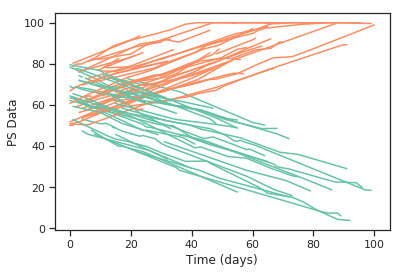

In [4]:
N_data = df.shape[0]
N_pt = pt_df.shape[0]
idx = df.pt.values
t = df.t.values
y = df.y_ps.values

for pt in range(1, 101):
    idx_pt = idx == pt
    if np.count_nonzero(idx_pt) < 1:
        continue
    t_pt = t[idx_pt]
    y_pt = y[idx_pt]
    if pt_df.A[pt] == 1:
        c = "C0"
    else:
        c = "C1"
    plt.plot(t_pt, y_pt, color=c)
plt.xlabel("Time (days)")
plt.ylabel("PS Data")

In [5]:
N_pt = pt_df.shape[0]
N_data = df.shape[0]

x = np.zeros((df.shape[0], 3))
x[:, 0] = 1
x[:, 1] = df.At.values
x[:, 2] = df.Bt.values

z = np.zeros((df.shape[0], 2))
z[:, 0] = 1
z[:, 1] = df.t.values

data = dict(
    N_pt = N_pt,
    N_data = N_data,
    N_tx = 2,
    idx = df.pt.values.tolist(),
    x = x.tolist(),
    z = z.tolist(),
    y = df.y_ps.values.tolist(),
    loc_beta = np.zeros(3).tolist(),
    scale_beta = [1e1, 1e0, 1e0],
    scale_eps = 2.5e0,
    scale_u = [2.5e0, 2.5e-1]
)
json.dump(data, open("data.json", "w"))

(0, 100)

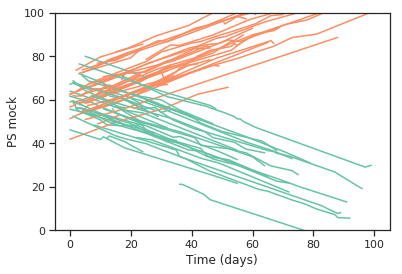

In [6]:
beta_A = -0.5
beta_B = 0.5

sigma_u0 = 1e1
sigma_u1 = 1e0
sigma_eps = 1e1

sigma_u0 = 3e0
sigma_u1 = 1e-1
sigma_eps = 1e0

beta = np.array([60, beta_A, beta_B])

u = np.random.randn(N_pt, 2)
u[:, 0] = sigma_u0 * u[:, 0]
u[:, 1] = sigma_u1 * u[:, 1]

u_data = np.zeros((N_data, 2))
for pt in range(1, N_pt + 1):
    idx_pt = np.arange(N_data)[idx == pt]
    u_data[idx_pt] = u[pt - 1]
    
u_data[:, 0] = sigma_u0 * u_data[:, 0]
u_data[:, 1] = sigma_u1 * u_data[:, 1]

eta = (x @ beta) + np.array([np.dot(z[i], u_data[i]) for i in range(N_data)])
y_forward = eta + sigma_eps * np.random.randn(N_data)

for pt in range(1, 101):
    idx_pt = np.array(idx) == pt
    if np.count_nonzero(idx_pt) < 1:
        continue
    t_pt = t[idx_pt]
    x_pt = x[idx_pt]
    y_pt = y_forward[idx_pt]
    if pt_df.loc[pt, "A"] == 1:
        c = "C0"
    else:
        c = "C1"
    plt.plot(t_pt, y_pt, color=c)
plt.xlabel("Time (days)")
plt.ylabel("PS mock")
plt.ylim(0, 100)

## Outputs

In [7]:
# %shell ./lmm sample num_samples=2000 num_warmup=1000 data file=data.json

In [8]:
df = pd.read_csv("output.csv", comment="#")
df.head()

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,beta.1,beta.2,beta.3,...,y_ppc.479,y_ppc.480,y_ppc.481,y_ppc.482,y_ppc.483,y_ppc.484,y_ppc.485,y_ppc.486,y_ppc.487,y_ppc.488
0,-1036.15,0.760650,0.074788,6,63,0,1130.40,64.2115,-0.408897,0.485079,...,67.3135,48.8064,44.4195,52.9441,44.1386,44.9138,39.8742,24.5185,19.2229,17.01980
1,-1031.90,0.907450,0.074788,6,63,0,1125.31,64.3032,-0.424907,0.493406,...,67.2898,51.2882,42.3267,45.6568,40.0909,35.9978,32.8008,18.1649,18.3228,10.92480
2,-1043.92,0.984756,0.074788,6,63,0,1138.16,63.8406,-0.468755,0.467072,...,61.6514,50.2725,41.1862,40.5924,46.3327,38.4316,43.5307,21.5758,16.5199,9.34752
3,-1044.67,0.785419,0.074788,6,63,0,1149.09,63.7102,-0.421284,0.516628,...,64.3427,51.6847,43.9840,49.4105,46.6177,39.3530,36.7046,22.3153,18.2713,8.02065
4,-1048.28,0.993265,0.074788,6,63,0,1154.67,64.2750,-0.450571,0.507125,...,61.7601,48.3648,43.9647,50.4367,42.1016,46.0083,48.4618,23.5437,15.4303,16.45550


In [9]:
keys = ["beta.1", "beta.2", "beta.3", "s_eps", "sigma_u.1", "sigma_u.2"]

labels = [r"$\beta_0$", r"$\beta_A$", r"$\beta_B$", 
          r"$\sigma_\epsilon$", r"$\sigma_{u_0}$", r"$\sigma_{u_1}$"]

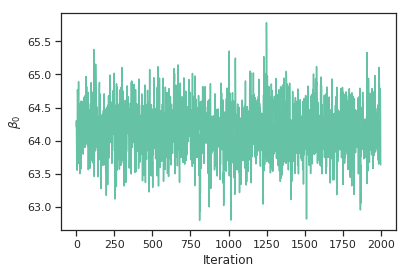

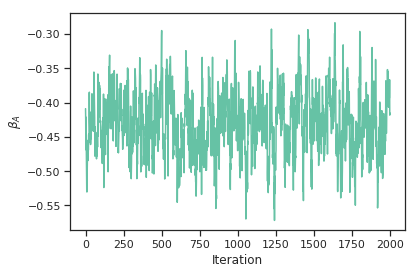

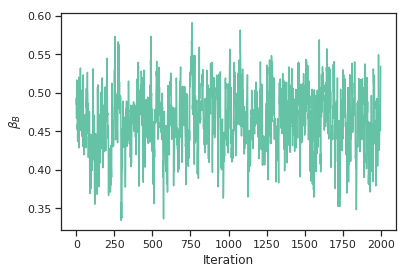

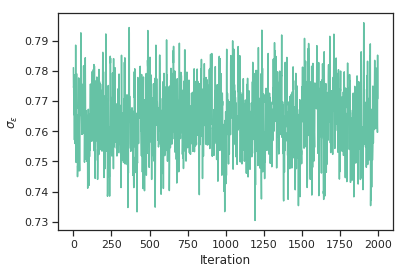

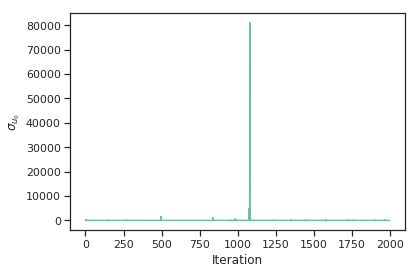

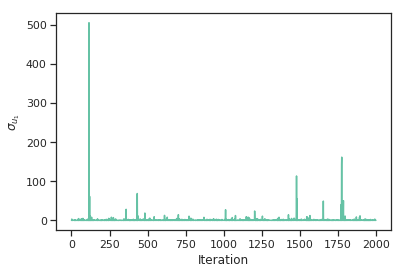

In [10]:
for i, key in enumerate(keys):
    label = labels[i]
    chain = df.loc[:, key].values
    plt.plot(chain)
    plt.xlabel("Iteration")
    plt.ylabel(label)
    plt.show()

In [11]:
def invcdf_cauchy(y, loc, scale):
    return loc + scale * np.tan(np.pi * (y - 0.5))

loc_beta = np.array(data["loc_beta"])
scale_beta = np.array(data["scale_beta"])
scale_u = np.array(data["scale_u"])
scale_eps = data["scale_eps"]

N_samples = df.shape[0]
N_params = len(keys)

prior_samples = np.empty((N_samples, len(keys)))
for i in range(len(loc_beta)):
    prior_samples[:, i] = loc_beta[i] + scale_beta[i] * np.random.randn(N_samples)

# sigma_epsilon
prior_samples[:, 3] = invcdf_cauchy(0.5 * np.random.rand(N_samples) + 0.5, 0, scale_eps)
# prior_samples[:, 3] = 0.5 * np.random.rand(N_samples) + 0.5

# sigma_u0
prior_samples[:, 4] = invcdf_cauchy(0.5 * np.random.rand(N_samples) + 0.5, 0, scale_u[0])
# prior_samples[:, 4] = 0.5 * np.random.rand(N_samples) + 0.5

# sigma_u1
prior_samples[:, 5] = invcdf_cauchy(0.5 * np.random.rand(N_samples) + 0.5, 0, scale_u[1])
# prior_samples[:, 5] = 0.5 * np.random.rand(N_samples) + 0.5

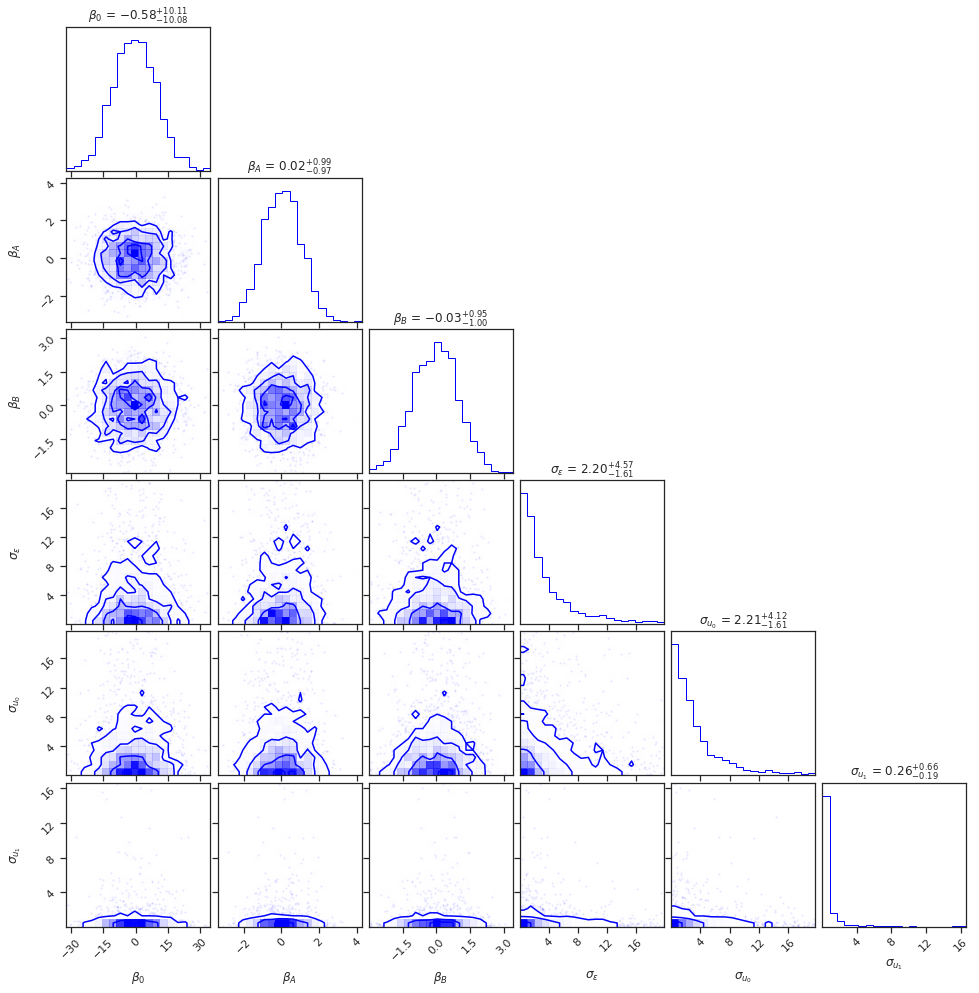

In [12]:
sigma_max = 20

pick = (prior_samples[:, 3] < sigma_max) & (prior_samples[:, 4] < sigma_max) & (prior_samples[:, 5] < sigma_max)

fig = corner(prior_samples[pick], labels=labels, 
             color="b", show_titles=True)
plt.savefig("figs/corner_prior_blmm.pdf")

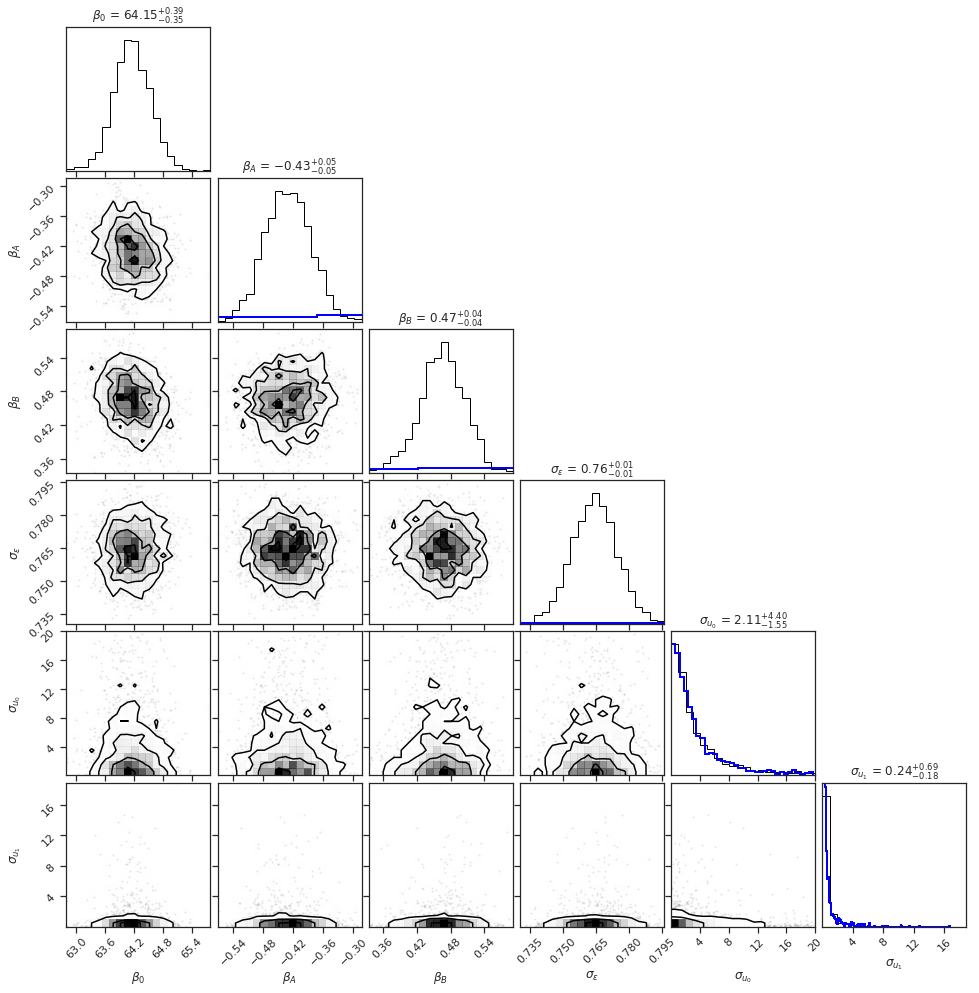

In [13]:
sigma_max = 20

samples = np.array([df.loc[:, key].values for key in keys]).T
pick = (samples[:, 3] < sigma_max) & (samples[:, 4] < sigma_max) & (samples[:, 5] < sigma_max)

fig = corner(samples[pick], labels=labels, show_titles=True,
             hist_kwargs=dict(density=True))

pick = (prior_samples[:, 3] < sigma_max) & (prior_samples[:, 4] < sigma_max) & (prior_samples[:, 5] < sigma_max)
for i in range(N_params):
    idx_ax = i + N_params * i
    ax = fig.axes[idx_ax]
    ax.hist(prior_samples[pick, i], color="b", lw=2,
            density=True, bins="auto", histtype="step")
plt.savefig("figs/corner_post_blmm.pdf")

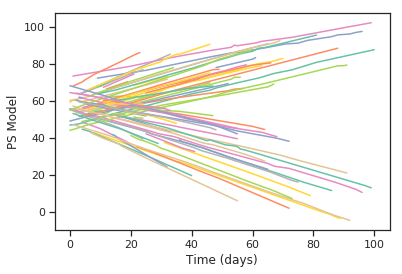

In [14]:
idx = data["idx"]
N_pt = data["N_pt"]
N_data = data["N_data"]
t = z[:, 1]
y = np.array(data["y"])

color = cycle(sns.color_palette("Set2"))

for pt in range(1, 101):
    idx_pt = np.array(idx) == pt
    if np.count_nonzero(idx_pt) < 1:
        continue
    t_pt = t[idx_pt]
    x_pt = x[idx_pt]
    y_ppc_lines = np.array([df.loc[:, f"y_ppc.{i}"] for i in np.arange(1, N_data + 1)[idx_pt]])
    y_ppc_low, y_ppc_med, y_ppc_high = np.percentile(y_ppc_lines, q=[0.16, 0.5, 0.84], axis=1)
    c = next(color)
    plt.plot(t_pt, y_ppc_med, color=c)
    # plt.fill_between(t_pt, y_ppc_low, y_ppc_high, color=c, alpha=0.2)
plt.xlabel("Time (days)")
plt.ylabel("PS Model")
plt.savefig("figs/ppc.pdf")

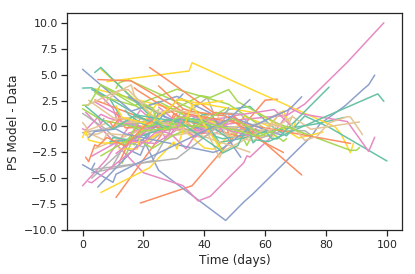

In [15]:
idx = data["idx"]
N_pt = data["N_pt"]
N_data = data["N_data"]
t = z[:, 1]
y = np.array(data["y"])

for pt in range(1, 101):
    idx_pt = np.array(idx) == pt
    if np.count_nonzero(idx_pt) < 1:
        continue
    t_pt = t[idx_pt]
    y_ppc_lines = np.array([df.loc[:, f"y_ppc.{i}"] for i in np.arange(1, N_data + 1)[idx_pt]])
    y_ppc_med = np.median(y_ppc_lines, axis=1)
    plt.plot(t_pt, y_ppc_med - y[idx_pt])
plt.xlabel("Time (days)")
plt.ylabel("PS Model - Data")
plt.savefig("figs/residuals.pdf")

In [16]:
idx = np.array(data["idx"])
N_pt = data["N_pt"]
N_data = data["N_data"]
t = z[:, 1]
y = np.array(data["y"])

u0_samples = np.array([df.loc[:, f"u.{i}.1"] for i in np.arange(1, N_pt + 1)])
u1_samples = np.array([df.loc[:, f"u.{i}.2"] for i in np.arange(1, N_pt + 1)])

x_A_pt = pt_df.A == 1
x_B_pt = pt_df.B == 1

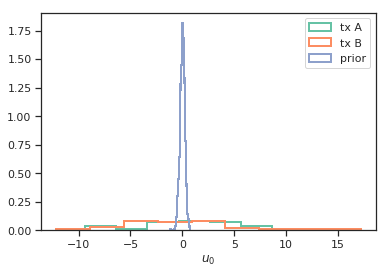

In [17]:
u0_med = np.median(u0_samples, axis=1)

kwargs = dict(density=True, bins="auto", histtype="step", lw=2)
plt.hist(u0_med[x_A_pt], color="C0", label="tx A", **kwargs)
plt.hist(u0_med[x_B_pt], color="C1", label="tx B", **kwargs)
plt.hist(np.random.randn(N_samples) * scale_u[1], color="C2", label="prior", **kwargs)
plt.legend(loc="best")
plt.xlabel("$u_0$")
plt.savefig("figs/u0_post.pdf")

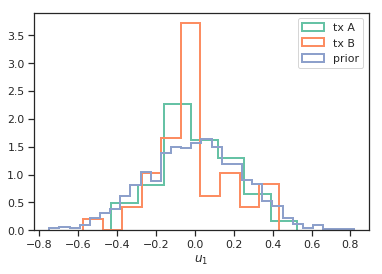

In [18]:
x_A_pt = pt_df.A == 1
x_B_pt = pt_df.B == 1

u1_med = np.median(u1_samples, axis=1)

kwargs = dict(density=True, bins="auto", histtype="step", lw=2)
plt.hist(u1_med[x_A_pt], color="C0", label="tx A", **kwargs)
plt.hist(u1_med[x_B_pt], color="C1", label="tx B", **kwargs)
plt.hist(np.random.randn(N_samples) * scale_u[1], color="C2", label="prior", **kwargs)
plt.legend(loc="best")
plt.xlabel("$u_1$")
plt.savefig("figs/u1_post.pdf")